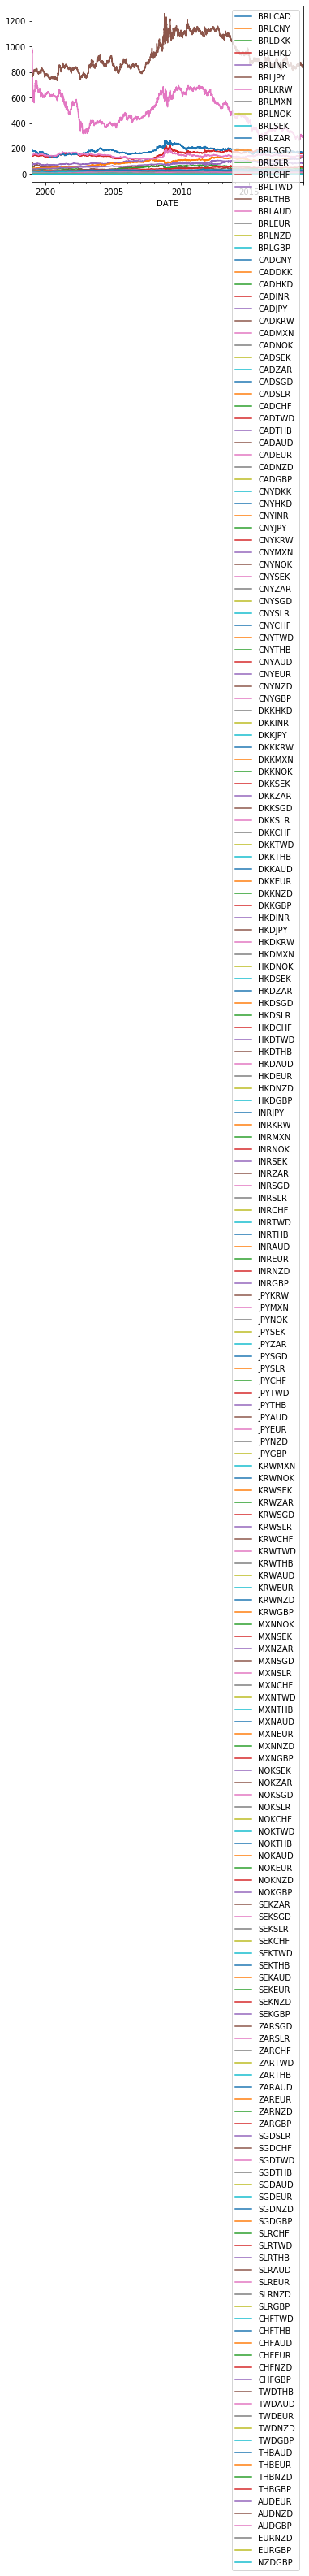

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
from Preprocessing.labeling import resample_close, get_t1, get_events, get_lookback_vol
from Research.fx_utils import fx_data_import, bbg_data_import
from Research.FXTesting import pca_distance_loop, get_nonusd_pair_data, get_nonusd_pairs, get_nonusd_close
from Preprocessing.sampling import _get_num_concurrent_events
from Preprocessing.etf_trick import ETFTrick
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl

home_machine = True

# implement citi reversion
# start with just AUDNZD
pair='AUDNZD'
c1 = 'USDAUD'
c2 = 'USDNZD'


if home_machine:
    close = fx_data_import()

    pair_closes = get_nonusd_close(close, nonusd_pairs)
    tr_df = crosses.dropna(how='any')
else:
    close, yields = bbg_data_import(vs_dollar=True)
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes, cross_yields = get_nonusd_pair_data(close, yields, nonusd_pairs)
    cross_yields = cross_yields.fillna(0)/100./365.
    
#   if we wanted to drop the union of NAs
#    cross_yields = crosses.merge(yields, left_index=True, right_index=True, suffixes=('_px','_yld'))


group_matrix = pca_distance_loop(close, 100, 4, 0.2, nonusd_pairs, components_to_use=[1,2,3])

zscores = lookback_zscore(pair_closes, 30, 200)
signals = zscore_signal(zscores, 2, 'Reversion')
group_signals = signals.multiply(group_matrix.loc[signals.index[0]:])
for pair in nonusd_pairs:
    #check if we have yields
    if home_machine:
        tr_s = pair_closes[pair]
    else:
        weights = pd.DataFrame(np.ones(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
        # ETF trick on one pair
        tr = ETFTrick(pair_closes[pair].shift(1), pair_closes[pair], weights, cross_yields[pair])
        tr_s = tr.get_etf_series()
    
    events0 = zscore_sizing(group_signals[pair], pair_closes[pair], 300, 30, 100)
    events = generate_pnl(events0, tr_s)

